##### Imports

In [15]:
import networkx as nx
import itertools
from functools import lru_cache
from scipy.special import comb
import math
from enum import Enum
import matplotlib.pyplot as plt
from typing import Any, List, Dict, Set, Tuple
import time

#TODO: Mantener una consistencia entre el Camel Cases o el Snake Case, revisar que se usa en Python

#### Digraph

In [16]:
def isLeaf(node, dag : nx.DiGraph):
    return dag.out_degree(node) == 0

def isRoot(node, dag : nx.DiGraph):
    return dag.in_degree(node) == 0

#### Classify the nodes in the DAG

In [17]:

class NodeState(Enum):
    ANCESTOR = 1
    DESCENDANT = 2
    UNRELATED = 3
    FEATURE = 4


#Classify the nodes into the category descendants, ancestors and unrelated. 

def classifyNodes(dag: nx.DiGraph, x_i : Any, nodes_classification : Dict[Any, NodeState]):
    ancestors = nx.ancestors(dag, x_i)
    descendants = nx.descendants(dag, x_i)
    unrelated_roots = []
    for node in dag.nodes():
        if node in ancestors:
            nodes_classification[node] = NodeState.ANCESTOR
        elif node in descendants:
            nodes_classification[node] = NodeState.DESCENDANT
        elif node == x_i:
            nodes_classification[node] = NodeState.FEATURE
        else:
            nodes_classification[node] = NodeState.UNRELATED
            parents =  list(dag.predecessors(node))
            parentIsAncestor = (parents[0] in ancestors) if len(parents) != 0 else False
            if isRoot(node, dag) or parentIsAncestor:
                unrelated_roots.append(node)


    return unrelated_roots


#### Equivalence Class definition

In [18]:
class NodePosition:

    def __init__(self, node_name, appears_after_xi : bool) -> None:
        self.node_name = node_name
        self.appears_after_xi = appears_after_xi
        self.relative_position = 'After' if appears_after_xi else 'Before'

    def isBefore(self):
        return not self.appears_after_xi
    
    def nodeName(self):
        return self.node_name

    def __str__(self):
        return f"({self.node_name}, {self.relative_position})"

class EquivalenceClass:

    def __init__(self, unrelated_node_position : Set[NodePosition], left_topo=1, right_topo=1):
        self.position = unrelated_node_position
        self.left_topo = left_topo
        self.right_topo = right_topo
        if len(unrelated_node_position) != 0:
            self.parent = list(unrelated_node_position)[0].nodeName()
    
    def nodes_before(self): #The nodes before x_i
        positions = filter(lambda node_pos : node_pos.isBefore(), self.position)
        return list(map(lambda p : p.nodeName(),  positions))
    
    def nodes_after(self): #The nodes after x_i
        positions = filter(lambda node_pos : not node_pos.isBefore(), self.position)
        return list(map(lambda p : p.nodeName(),  positions))

    def num_nodes_before(self): 
        return len(self.nodes_before())
    
    def num_nodes_after(self):
        return len(self.position) - self.num_nodes_before()
    
    def classSize(self): #Number of topological orders
        return self.left_topo * self.right_topo
    
    def __str__(self):
        
        return f"Equivalence Class (NodesBefore={self.nodes_before()}, NodesAfter={self.nodes_after()}, Size={self.classSize()})"
    
    def addParent(self, parent : NodePosition):
        self.addNodes({parent})
        self.parent = parent.node_name

    def addNodes(self, nodes : set[NodePosition]):
        self.position = self.position.union(nodes)

    def classParent(self):
        return self.parent

    def addLeftTopo(self, leftTopos : int):
        self.left_topo *= leftTopos


### Auxiliary Functions

#### Posible Orderings Formula

In [19]:
def multinomial_coefficient(args) -> int:
    n = sum(args)
    coeff = 1
    for k in args:
        coeff *= comb(n, k, exact=True)
        n -= k
    return int(coeff)

def getLeftElementsOfClasses(ancestors : List[Any], dag : nx.DiGraph, unrClasses : List[EquivalenceClass]):
    leftElements = []
    unrelatedTrees = 0

    for unrClass in unrClasses: #These trees will always be available to use, because they are not related to any ancestor. They can go before the root of the ancestors even.
            if isRoot(unrClass.classParent(), dag):
                leftElements.append(unrClass.num_nodes_before())
                unrelatedTrees += 1

    for ancestor in ancestors:
        ancestorChildren = list(dag.successors(ancestor))
        for unrClass in unrClasses:
            if unrClass.classParent() in ancestorChildren:
                leftElements.append(unrClass.num_nodes_before())
    return leftElements, unrelatedTrees

# The idea would be that it has the left elements of each unrelated class, ordered by the ascendant node that is their parent. 

def getPossibleCombinations(leftElementsOfClasses: List[int], elementsToSelect: int) -> List[List[int]]:
    def backtrack(index, current_combination, current_sum, maximumAmount):
        # If the current sum equals the required elementsToSelect, add the combination to the result
        if current_sum == elementsToSelect:
            result.append(list(current_combination))
            return
        
        if current_sum > elementsToSelect or index == len(leftElementsOfClasses) or current_sum + maximumAmount < elementsToSelect:
            return
        
        for value in range(leftElementsOfClasses[index] + 1):
            current_combination.append(value)
            backtrack(index + 1, current_combination, current_sum + value, maximumAmount - leftElementsOfClasses[index])
            current_combination.pop() 

    result = []
    backtrack(0, [], 0, sum(leftElementsOfClasses))
    return result

# TODO: Add more pruning techniques. 

def numberOfUnrelatedSubtrees(node, dag : nx.DiGraph, classification : Dict[Any, NodeState]) -> int:
    return len([child for child in dag.successors(node) if classification[child] == NodeState.UNRELATED])


def removePutElements(putElements, leftElementsOfClasses : List[int]):
    for i, put in enumerate(putElements):
        leftElementsOfClasses[i] -= put

def addPutElements(putElements, leftElementsOfClasses : List[int]):
    for i, put in enumerate(putElements):
        leftElementsOfClasses[i] += put

def possibleLeftOrders(actualPosition : int, leftElementsOfClasses : List[int], ancestorIndex : int, classesToUse : int , ancestors : List[Any], dag : nx.DiGraph, classification : Dict[Any, NodeState], memo: Dict[Tuple[int, Tuple[int], int, int], int]) -> int:
    
    state = (actualPosition, tuple(leftElementsOfClasses), ancestorIndex, classesToUse)

    if state in memo:
        return memo[state]

    if (sum(leftElementsOfClasses) == 0): #There are no more elements to select
        return 1
    
    totalOrders = 0
    #I just need to select all of the elements of the classes.
    if (ancestorIndex == len(ancestors)): #I have already selected all the ancestors
        
        for comb in getPossibleCombinations(leftElementsOfClasses, sum(leftElementsOfClasses)):
            totalOrders += multinomial_coefficient(comb)
        
        memo[state] = totalOrders
        return totalOrders

    actualAncestor = ancestors[ancestorIndex]
    usableElements = leftElementsOfClasses[:classesToUse]

    for ancestorPosition in range(actualPosition, actualPosition + sum(usableElements) + 1):
        positionsToFill = ancestorPosition - actualPosition
        for comb in getPossibleCombinations(usableElements, positionsToFill):
            removePutElements(comb, leftElementsOfClasses)
            newClassesToUse = classesToUse +  numberOfUnrelatedSubtrees(actualAncestor, dag, classification)
            totalOrders += multinomial_coefficient(comb) * possibleLeftOrders(ancestorPosition+1, leftElementsOfClasses, ancestorIndex + 1, newClassesToUse, ancestors, dag, classification, memo)
            addPutElements(comb, leftElementsOfClasses)
    
    memo[state] = totalOrders
    return totalOrders

# TODO: Make some of the variables global, so that I don't need to pass them as arguments

#TODO : Improve the memoization data structure. Look if there is a structure that is useful for this kind of problem. ¿Maybe use lru_cache or other structure?


#### Equivalence Classes manipulation

In [20]:
def unionOf(equivalence_classes : List[EquivalenceClass], addLeftToposOrder : bool = True) -> EquivalenceClass:
    n = len(equivalence_classes)
    positions = set()
    nodes_before = [0]*n
    nodes_after = [0]*n
    left_topos = [0]*n
    right_topos = [0]*n
    for i,eq_class in enumerate(equivalence_classes):
        nodes_before[i] = eq_class.num_nodes_before()
        nodes_after[i] = eq_class.num_nodes_after()
        left_topos[i] = eq_class.left_topo
        right_topos[i] = eq_class.right_topo
        positions = positions.union(eq_class.position)

    left_size = math.prod(left_topos)
    if addLeftToposOrder:
        left_size *= multinomial_coefficient(nodes_before)  
        
    right_size = multinomial_coefficient(nodes_after) * math.prod(right_topos)
    return EquivalenceClass(positions, left_size, right_size)

# TODO: Make some of the variables global, so that I don't need to pass them as arguments

def lastUnionOf(unr_classes : List[List[EquivalenceClass]], ancestors : List[Any], descendants : List[Any], descendantsTopoSorts : int, dag : nx.DiGraph, classification : Dict[Any, NodeState]) -> List[EquivalenceClass]:
    classes_combinations = list(itertools.product(*unr_classes)) #Generate al the possible combinations for each eqClass of each child with the eqClass of the other children. 
    
    descendants_position = set([NodePosition(des, True) for des in descendants])
    descendants_eqClass = EquivalenceClass(descendants_position,1, descendantsTopoSorts) 
    classes = []
    # All the descendants appear after the feature node, because all of them appear before it then it has 1 rigth_topo (the empty one). 

    if (len(ancestors) == 0):
        classes = list(map(lambda mix : unionOf(list(mix)), classes_combinations))
        
        if len(descendants) != 0:
            classes = [unionOf([descendants_eqClass, mix]) for mix in classes]

    else:
        for unr_class in classes_combinations:
            leftElements, unrelatedTrees = getLeftElementsOfClasses(ancestors, dag, unr_class)
            classesToUse = unrelatedTrees
            ascendantsCombinationsWithUnrelated = possibleLeftOrders(0, leftElements, 0, classesToUse , list(ancestors), dag, classification, {})
            ascendants_position = set([NodePosition(des, False) for des in descendants])

            eqClass = unionOf(unr_class, False)

            eqClass.addNodes(ascendants_position)
            eqClass.addLeftTopo(ascendantsCombinationsWithUnrelated)

            if (len(descendants) != 0):
                eqClass = unionOf([eqClass, descendants_eqClass])
                
            classes.append(eqClass)
    
    return classes


#### Topological sorts

In [21]:
#Returns a hash that is the binary number which has 0 or 1 in the i-th position if the i-th unrelated node is before or after x_i

class TopoSortHasher:
    def __init__(self, nodes_classification: Dict[Any, NodeState]):
        self._unrelated_nodes_ids = self._get_unrelated_nodes(nodes_classification)

    def _get_unrelated_nodes(self, nodes_classification: Dict[Any, NodeState]):
        unrelated_nodes = list(filter(lambda node: nodes_classification[node] == NodeState.UNRELATED, nodes_classification.keys()))
        self._unrelated_nodes_ids = {node: i for i, node in enumerate(unrelated_nodes)}
        return self._unrelated_nodes_ids

    def hashTopoSort(self, topoSort: List[Any], x_i: Any) -> int:
        unrelated_nodes = self._unrelated_nodes_ids
        hash_val = 0
        for node in topoSort:
            if node == x_i:
                break
            if node in unrelated_nodes:
                hash_val += 2 ** unrelated_nodes[node]
        return hash_val


In [22]:
#Returns the size of the tree and the number of topological sorts

def sizeAndNumberOfTopoSorts(node, dag : nx.DiGraph):
    if isLeaf(node, dag):
        return 1,1
    
    childrenSubtreeSizes = []
    children_topoSorts = []

    
    for child in dag.successors(node):
        child_size, child_topos =  sizeAndNumberOfTopoSorts(child,dag)
        children_topoSorts.append(child_topos)
        childrenSubtreeSizes.append(child_size)
        

    topos = multinomial_coefficient(childrenSubtreeSizes) * math.prod(children_topoSorts)
    return sum(childrenSubtreeSizes)+1, topos

    
def topoSortsFrom(node, dag : nx.DiGraph):
   _, topos = sizeAndNumberOfTopoSorts(node, dag)
   return topos

#TODO : Add dynamic programming so that each node knows its result.

def allTopoSorts(dag : nx.DiGraph):
    #Add a root node to the graph that is connected to all the roots of the graph.
    roots = [node for node in dag.nodes() if isRoot(node, dag)]

    dag.add_node('Root')

    for root in roots:
        dag.add_edge('Root', root)
        
    res = topoSortsFrom('Root', dag)
    dag.remove_node('Root')
    return res

### Equivalence Classes Formulas

#### Recursive Equivalence Class formula

In [23]:
def unrelatedEquivalenceClassesSizes(node, dag : nx.DiGraph) -> List[EquivalenceClass]:
    if isLeaf(node, dag):
        classes = []
        for x in [False, True]:
           classes.append(EquivalenceClass({NodePosition(node, x)}))
        return classes
    
    children_classes = list(map(lambda child : unrelatedEquivalenceClassesSizes(child,dag), dag.successors(node)))

    classes_combinations = list(itertools.product(*children_classes)) #Generate al the possible combinations for each eqClass of each child with the eqClass of the other children. 
    
    # All the equivalence classes will have this node in the left part. 

    classes = list(map(lambda mix : uniteChildrenAndAddParent(node, list(mix)), classes_combinations))

    allRight = unionOf(list(classes_combinations[len(classes_combinations)-1]))
    if allRight.num_nodes_before() == 0:
        allRight.addParent(NodePosition(node, True))
        classes.append(allRight)
        # If the parent is to the right, then all of the children should be after the feature node

        # TODO: I think that this kind of union (all in the right part) will always be the last element of classes_combinations, so we can just take the 
        # first element of classes_combination to do this, I need to review this.
    return classes

#TODO : Add dynamic programming so that it stores the result of the run for each node, or it stores some results so that it can reconstruct the solution.

def uniteChildrenAndAddParent(node, equivalence_classes : List[EquivalenceClass]) -> EquivalenceClass:
        union = unionOf(equivalence_classes)
        union.addParent(NodePosition(node, False))

        return union

#They need to be ordered in the same way that the nodes are ordered in the graph, because in the possibleLeftOrders we are putting them assuming they have the same order as in the graph

def orderedAncestors(dag : nx.DiGraph, feature_node) -> List[Any]:
    ancestors = nx.ancestors(dag, feature_node)
    topo_sorted_nodes = list(nx.topological_sort(dag))
    ordered_ancestors = [n for n in topo_sorted_nodes if n in ancestors]
    
    return ordered_ancestors


def recursiveEquivalenceClassesSizes(dag : nx.DiGraph, unr_roots : List[Any], hasher : TopoSortHasher, feature_node, nodes_classification : Dict[Any, NodeState]) -> List[EquivalenceClass]:
    unr_classes = list(map(lambda child : unrelatedEquivalenceClassesSizes(child,dag), unr_roots))
    ancestors = orderedAncestors(dag, feature_node)
    descendants = list(nx.descendants(dag, feature_node))

    descendantsTopoSorts = topoSortsFrom(feature_node, dag)
    recursiveClassesSizes = lastUnionOf(unr_classes, ancestors, descendants, descendantsTopoSorts, dag, nodes_classification)

    recursiveClassesSizes = hashEquivClasses(recursiveClassesSizes, hasher, feature_node, ancestors, descendants)
    return recursiveClassesSizes



def hashEquivClasses(equivClasses : List[EquivalenceClass], hasher : TopoSortHasher , feature_node, ancestors, descendants):
    hashedClasses = {}
    for eqClass in equivClasses:
        topoSortForClass = ancestors + eqClass.nodes_before() + [feature_node] + eqClass.nodes_after() + descendants
        # This is not a real toposort, because the nodes_before and the nodes_after are not in a topological order, but it is a way to represent the class
        hash = hasher.hashTopoSort(topoSortForClass, feature_node)
        
        representationOfClass = f'Feature node : {feature_node} \n Nodes before: {eqClass.nodes_before()} \n Nodes after {eqClass.nodes_after()} \n Ancestors : {ancestors} \n Descendants:  {descendants}'
        hashedClasses[hash] = [representationOfClass,  eqClass.classSize()]
    
    return hashedClasses
        

#### Naive Equivalence Classes

In [24]:
def naiveEquivalenceClassesSizes(all_topo_sorts : List[List[Any]], feature_node : Any, hasher : TopoSortHasher):
      
   result = {} 
   for topoSort in all_topo_sorts:
      hash = hasher.hashTopoSort(topoSort, feature_node)
      actual_value = result.get(hash, [topoSort, 0])
      result[hash] = [actual_value[0], actual_value[1] + 1] 
      # It has a representative of each class and the number of topological orders that are in that class.

   return result

#TODO: Here I don't need the topological orders with the descendants of feature_node, I can remove them and then multiply the number of topological orders of each class. 
# To do this I just need to calculate the "merging" of this possible topological orders as I do in the recursive approach. So when I calculate all_topo_sorts I
# can do it with only the unrelated nodes and the ascendants, removing the descendants. But to do do this I need to recalculate all_topo_sorts for each feature node.


### Testing functions

In [25]:
def assertEquivalenceClassesForNode(dag: nx.DiGraph, feature_node, all_topo_sorts: List[List[Any]], timing_dict: Dict[str, Dict[str, float]]):
    
    nodes_classification = {}
    unr_roots = classifyNodes(dag, feature_node, nodes_classification)
    hasher = TopoSortHasher(nodes_classification)

    # Naive approach
    start_time = time.time()
    naiveClassesSizes = naiveEquivalenceClassesSizes(all_topo_sorts, feature_node, hasher)
    end_time = time.time()
    timing_dict[feature_node]['Naive Formula'] = end_time - start_time

    # Recursive approach
    start_time = time.time()
    recursiveClassesSizes = recursiveEquivalenceClassesSizes(dag, unr_roots, hasher, feature_node, nodes_classification)
    end_time = time.time()
    timing_dict[feature_node]['Recursive Formula'] = end_time - start_time

    timing_dict[feature_node]['Number of equivalence classes'] = len(naiveClassesSizes.keys())
    
    # Assert that each equivalence class has the same number of elements.
    assert len(naiveClassesSizes.keys()) == len(recursiveClassesSizes.keys())

    for eqClassHash in naiveClassesSizes.keys():
        clSize1 = naiveClassesSizes[eqClassHash][1]
        clTopo1 = naiveClassesSizes[eqClassHash][0]
        try: 
            clSize2 = recursiveClassesSizes[eqClassHash][1]
            clTopo2 = recursiveClassesSizes[eqClassHash][0]
        except KeyError:
            raise AssertionError(f"The equivalence class {eqClassHash} is not present in the recursive approach. \n Naive Approach: Topo {clTopo1}, Size {clSize1} \n Feature Node: {feature_node}")
        if (clSize1 != clSize2):
            raise AssertionError(f"The sizes of the equivalence classes are not equal. \n Naive Approach: Topo {clTopo1}, Size {clSize1} \n Recursive Approach: Topo {clTopo2}, Size {clSize2} \n Feature Node: {feature_node}")

def assertEquivClassesForDag(dag: nx.DiGraph, nodesToEvaluate = None) -> Dict[str, float]:
    timing_dict = {}
    
    # Measure time for all topological sorts
    start_time = time.time()
    all_topo_sorts = list(nx.all_topological_sorts(dag))
    assert len(all_topo_sorts) == allTopoSorts(dag)
    end_time = time.time()
    timing_dict['Time Of Topological Sorts'] = end_time - start_time
    timing_dict['Number of Topological Sorts'] = len(all_topo_sorts)
    
    nodesToEvaluate = nodesToEvaluate if nodesToEvaluate != None else list(dag.nodes)
    for node in nodesToEvaluate:
            timing_dict[node] = {}
            assertEquivalenceClassesForNode(dag, node, all_topo_sorts, timing_dict)
    
    return timing_dict

def drawGraph(dag : nx.DiGraph):
    pos = nx.spring_layout(dag)
    nx.draw(dag, pos, with_labels=True)
    plt.show()

## Examples

### Empty graph

In [26]:
numNodes = 5

emptyGraph = nx.DiGraph()
nodes = [i for i in range(numNodes)]
emptyGraph.add_nodes_from(nodes)

#drawGraph(emptyGraph)
res = assertEquivClassesForDag(emptyGraph)

### Naive Bayes

In [27]:
def naiveBayesOf(numNodes : int):
    naive_bayes = nx.DiGraph()
    nodes = [i for i in range(numNodes)]
    naive_bayes.add_nodes_from(nodes)
    root = list(naive_bayes.nodes)[0]
    for node in nodes:
        if node != root:
            naive_bayes.add_edge(root, node)
    return naive_bayes

numNodes = 7
naiveBayes = naiveBayesOf(numNodes)

#drawGraph(naiveBayes)

res = assertEquivClassesForDag(naiveBayes)

### Naive Bayes with Path

In [28]:
numNodes = 7
lengthOfPath = 10

naiveBayesWithPath = naiveBayesOf(numNodes)

for path_node in range(numNodes,numNodes+lengthOfPath):
    naiveBayesWithPath.add_node(path_node)
    naiveBayesWithPath.add_edge(path_node-1, path_node)

#drawGraph(naiveBayesWithPath)
res = assertEquivClassesForDag(naiveBayesWithPath, [9])


### Multiple Paths

In [29]:
def multiplePaths(numPaths, nodesPerPath) -> nx.DiGraph:
    multiplePaths = nx.DiGraph()
    multiplePaths.add_node(0)

    nodeCounter = 0
    for path in range(1,numPaths+1):
        for node in range(1,nodesPerPath+1):
            if node != 1:
                multiplePaths.add_edge(nodeCounter-1, nodeCounter)
            nodeCounter += 1
    
    return multiplePaths


numberOfPaths = 3
pathLenght = 3

multiplePathGraph = multiplePaths(numberOfPaths, pathLenght)
#drawGraph(multiplePathGraph)
res = assertEquivClassesForDag(multiplePathGraph)

### Balanced Tree

In [30]:
def balancedTree(height: int, branchingFactor: int = 2) -> nx.DiGraph:

    balanced_tree = nx.DiGraph()
    current_level_nodes = [0]
    balanced_tree.add_node(0)
    node_counter = 1
    
    for _ in range(1, height):
        next_level_nodes = []
        for parent in current_level_nodes:
            for _ in range(branchingFactor):
                balanced_tree.add_node(node_counter)
                balanced_tree.add_edge(parent, node_counter)
                next_level_nodes.append(node_counter)
                node_counter += 1
        current_level_nodes = next_level_nodes
    
    return balanced_tree

numLevels = 2
branchingFactor = 3
balanced_tree = balancedTree(numLevels, branchingFactor)

#drawGraph(balanced_tree)

res = assertEquivClassesForDag(balanced_tree)

### Testing of All Topo Sorts

In [31]:
def test_allTopos(graph):
    all_topos = allTopoSorts(graph)
    all_topo_sorts = list(nx.all_topological_sorts(graph))
    assert all_topos == len(all_topo_sorts), "allTopos and all_topological_sorts have different lengths"

 
# Test allTopos function for different graphs
test_allTopos(emptyGraph)
test_allTopos(naiveBayes)
test_allTopos(naiveBayesWithPath)
test_allTopos(multiplePathGraph)
test_allTopos(balanced_tree)

## Experimentation

### Auxiliary Functions

In [32]:

def measure_graph_data(dag: nx.DiGraph, nodesToEvaluate : List[Any]) -> Dict[str, Any]:

    times_per_node = []
    equiv_classes_per_node = []

    graph_data = assertEquivClassesForDag(dag, nodesToEvaluate)

    for node in nodesToEvaluate:
        node_data = graph_data[node]
        times_per_node.append(node_data['Recursive Formula'])
        equiv_classes_per_node.append(node_data['Number of equivalence classes'])


    def obtainMaxMinAvg(data):
        maxValue = max(data)
        maxValue = str(maxValue) + f', Index of node: {data.index(maxValue)}'
        minValue = min(data)
        minValue = str(minValue) + f', Index of node: {data.index(minValue)}'
        average = sum(data) / len(data)
        return maxValue, minValue, average
   
    longest_time, shortest_time, average_time = obtainMaxMinAvg(times_per_node)
    biggest_equiv_classes, smallest_equiv_classes, average_equiv_classes = obtainMaxMinAvg(equiv_classes_per_node)

    return {
        "allTopoSortsTime": graph_data['Time Of Topological Sorts'],
        "allTopoSortsNumber": graph_data['Number of Topological Sorts'],
        "recursiveLongestTime": longest_time,
        "recursiveShortestTime": shortest_time,
        "recursiveAverageTime": average_time,
        "biggestEquivClasses": biggest_equiv_classes,
        "smallestEquivClasses": smallest_equiv_classes,
        "averageEquivClasses": average_equiv_classes,
        "naive_formula_time": graph_data[nodesToEvaluate[0]]['Naive Formula']  
    }

def timeOfAllTopologicalSorts(dag, printTime = 500000, maxTopoSorts = 100000000):
    allTopoSorts = []
    timing_dict = {}
    start_time = time.time()
    for topoSort in nx.all_topological_sorts(dag):
        allTopoSorts.append(topoSort)
        if (len(allTopoSorts) % printTime == 0):
            timing_dict[len(allTopoSorts)]= time.time() - start_time
            print(f'Number of topological sorts: {len(allTopoSorts)}, time: {timing_dict[len(allTopoSorts)]}')
        if (len(allTopoSorts) == maxTopoSorts):
            break
    return timing_dict, allTopoSorts

def timeRecursiveFunctionParts(dag : nx.DiGraph, unr_roots : List[Any], hasher : TopoSortHasher, feature_node, nodes_classification : Dict[Any, NodeState]) -> List[EquivalenceClass]:
    run_data = {}

    start_time = time.time()
    unr_classes = list(map(lambda child : unrelatedEquivalenceClassesSizes(child,dag), unr_roots))
    end_time = time.time()
    run_data['Unrelated Classes Calculation'] = end_time - start_time

    ancestors = list(nx.ancestors(dag, feature_node))
    descendants = list(nx.descendants(dag, feature_node))

    descendantsTopoSorts = topoSortsFrom(feature_node, dag)
    start_time = time.time()
    recursiveClassesSizes = lastUnionOf(unr_classes, ancestors, descendants, descendantsTopoSorts, dag, nodes_classification)
    end_time = time.time()
    run_data['Last Union Calculation'] = end_time - start_time

    run_data['Number of equivalence classes'] = len(recursiveClassesSizes)

    return run_data

def timeRecursiveFunctionFor(dag, nodesToEvaluate):
    timing_dict = {}
    for feature_node in nodesToEvaluate:
        timing_dict[feature_node] = {}
        nodes_classification = {}
        unr_roots = classifyNodes(dag, feature_node, nodes_classification)
        hasher = TopoSortHasher(nodes_classification)
        # Recursive approach
        start_time = time.time()
        recursiveFunctionResult = timeRecursiveFunctionParts(dag, unr_roots, hasher, feature_node, nodes_classification)
        end_time = time.time()
        timing_dict[feature_node]['Recursive Formula'] = recursiveFunctionResult
        timing_dict[feature_node]['Total Time'] = end_time - start_time
    
        print(f'Node {feature_node} took {timing_dict[feature_node]["Total Time"]} seconds to run')
    return timing_dict

### Multiple paths with different lengths

In [33]:
def multiplePaths(numPaths, nodesPerPath) -> nx.DiGraph:
    multiplePaths = nx.DiGraph()
    multiplePaths.add_node(0)

    nodeCounter = 0
    for _ in range(1,numPaths+1):
        multiplePaths.add_node(nodeCounter)
        for node in range(1,nodesPerPath+1):
            if node != 1:
                multiplePaths.add_edge(nodeCounter-1, nodeCounter)
            nodeCounter += 1
    
    return multiplePaths

def timeMultiplePathsGraphs(numPaths, pathLength, startFrom = 1):
    graphsResults = {}
    for i in range(startFrom,numPaths+1):
        for j in range(startFrom,pathLength+1):
            graphToEvaluate = multiplePaths(i, j)
            #drawGraph(graphToEvaluate)
            nodesToEvaluate = list(range(0, j))
            #print(f'{i} Paths, {j} Length' + str(nodesToEvaluate))
            graphsResults[f'{i} Paths, {j} Length'] = measure_graph_data(graphToEvaluate, nodesToEvaluate)

    return graphsResults
    

numberOfPaths = 3
pathLenght = 2
graph = multiplePaths(numberOfPaths, pathLenght)
allTopos = allTopoSorts(graph)

res = timeRecursiveFunctionFor(graph, list(range(0, pathLenght)))
#res = timeMultiplePathsGraphs(numberOfPaths, pathLenght)



Node 0 took 0.0003082752227783203 seconds to run
Node 1 took 0.0007746219635009766 seconds to run


### Number of topological sorts

In [34]:

numberOfPaths = 4
pathLenght = 5
graph = multiplePaths(numberOfPaths, pathLenght)

#res = timeOfAllTopologicalSorts(graph)

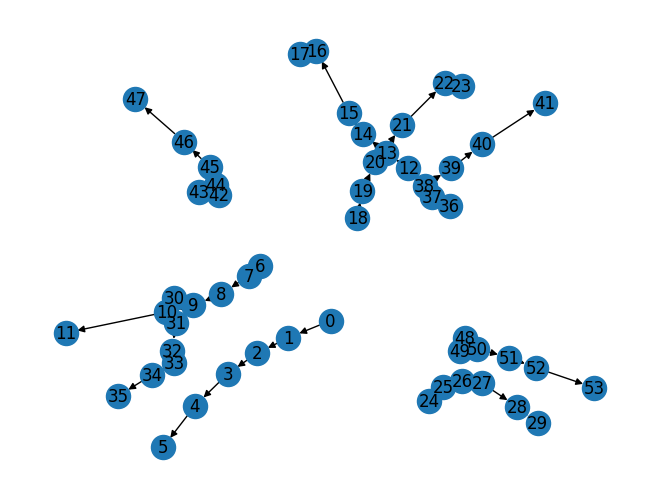

4439413043841128802009762476941510771390464000

In [35]:
balanced_tree = multiplePaths(9, 6)
drawGraph(balanced_tree)

allTopoSorts(balanced_tree)
